In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

In [4]:
class RectifiedLinearWithThreshold(nengo.RectifiedLinear):
    threshold = nengo.params.NumberParam('threshold')

    def __init__(self, amplitude=1, threshold=0):
        super().__init__(amplitude=amplitude)
        self.threshold = threshold

    def step_math(self, dt, J, output):
        output[...] = self.amplitude * np.maximum(self.threshold, J)

In [57]:
N = 10
J = 50
span = np.linspace(0, 1, N)
image = (np.sin(2*np.pi*span)+1)/2

model = nengo.Network()
with model:
    stim = nengo.Node(image)
    
    residual = nengo.Ensemble(n_neurons=N, dimensions=1,
                          neuron_type=RectifiedLinearWithThreshold(threshold=-np.inf),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
    reconstruct = nengo.Ensemble(n_neurons=N, dimensions=1,
                          neuron_type=RectifiedLinearWithThreshold(threshold=-np.inf),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
    
    v1 = nengo.Ensemble(n_neurons=J, dimensions=1,
                          neuron_type=RectifiedLinearWithThreshold(threshold=0.01),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
    
    nengo.Connection(v1.neurons, v1.neurons, synapse=0)
    
    learning_rate=1e-3
    tau = 0
    tau_learn = 0
    w = np.random.uniform(-0.1, 0.1, (J, N))
        
    
    nengo.Connection(residual.neurons, v1.neurons, transform=w, synapse=tau,
                      learning_rule_type=nengo.Oja(beta=0, pre_synapse=tau_learn, learning_rate=learning_rate))
        
    nengo.Connection(stim, residual.neurons, synapse=0)
    
    
    nengo.Connection(v1.neurons, reconstruct.neurons, transform=w.T, synapse=tau,
                     learning_rule_type=nengo.Oja(beta=0, pre_synapse=tau_learn, learning_rate=learning_rate))
    nengo.Connection(reconstruct.neurons, residual.neurons, transform=-1, synapse=None)
    
    p_v1 = nengo.Probe(v1.neurons)
    p_res = nengo.Probe(residual.neurons)
    p_recon = nengo.Probe(reconstruct.neurons)
    
    
sim = nengo.Simulator(model)
sim.run(0.5)
                        

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

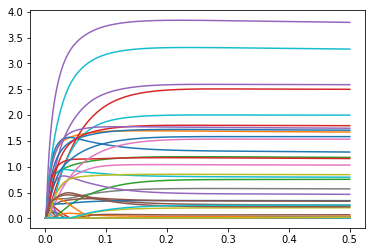

In [58]:
plt.plot(sim.trange(), sim.data[p_v1])
plt.show()

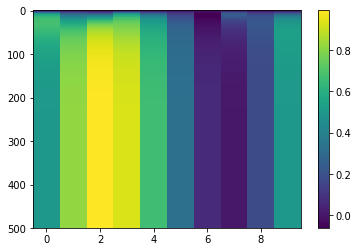

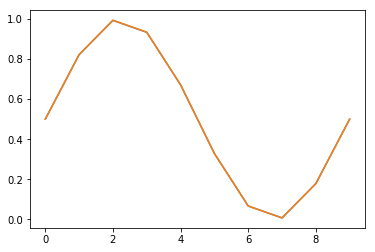

In [59]:
recon = sim.data[p_recon]
plt.imshow(recon, aspect='auto')
plt.colorbar()
plt.figure()
plt.plot(image)
plt.plot(recon[-1])


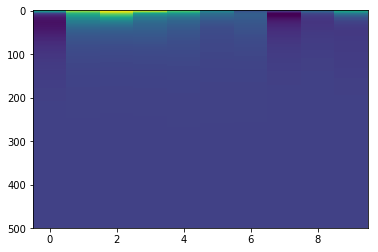

In [60]:
plt.imshow(sim.data[p_res][:,:], aspect='auto')